In [1]:
import rebound as rb
import celmech as cm
# import scipy
import numpy as np
import matplotlib.pyplot as plt
import radvel
import pandas as pd
import reboundx

# make font bigger
plt.rc('font', size=16)

In [2]:
hd_data = pd.read_csv('hd45364_rvs.csv', sep =';')
hd_data.BJD -= 2.4e6

In [3]:
#Least squares fit: 
fit_params = [ 2.28513053e+02, 7.27743508e+00, 5.39371890e+04, -1.78110513e-01, 
              -4.66450116e-02, 3.43378023e+02, 1.78603199e+01, 5.40186750e+04,
               1.32165040e-01, 9.73129308e-02, -5.29039776e-01] 

# star mass, g and auday to m/s conversion factor
STAR_MASS = 920  # 920 jupiter masses
G = 2.825e-7  # converting G to jupiter masses, au, and days
AUDAY_MS = 1.731e6  # conversion factor for au/day to m/s

def mass_to_semiamp(planet_mass, star_mass, period, eccentricity, inclination):
    """
    planet mass (jupiter masses) to semi amplitude
    """
    return ((2 * np.pi * G/period) ** (1/3) * (planet_mass * np.sin(inclination) / star_mass ** (2/3)) * (1/np.sqrt(1 - eccentricity ** 2)))

def semiamp_to_mass(semiamp, star_mass, period, eccentricity, inclination):
    """
    semi amplitude to planet mass (jupiter masses)
    """
    return (((2 * np.pi * G/period) ** (-1/3)) * (semiamp / np.sin(inclination)) * np.sqrt(1 - eccentricity ** 2) * (star_mass ** (2/3)))


def get_sim_from_params(params, inclination, integrator, time_base, star_mass = STAR_MASS, auday_ms = AUDAY_MS):
    """
    takes in params array, returns a rebound Simulation object with those parameters
    
    param params: numpy array of params:
    
    for i in range(0, num_planets):
    
    params[i + 0] is period
    params[i + 1] is semiamp
    params[i + 2] is tc (time of conjunction)
    params[i + 3] is sqrt(e) * cos(omega)
    params[i + 4] is sqrt(e) * sin(omega)
    
    params[5 * num_planets] is rv offset
    params[5 * num_planets + 1] is jit
    
    param inclination: inclination of system in the observation plane (pi/2 is in the plane of the sky, 0 is edge-on)
    param integrator: integrator to use, one of 'whfast' or 'ias15'
    param time_base: base time (to begin integration from) in the simulation
    """
    
    num_planets = int((len(params) - 1) / 5) # -2 because there are rv_offset and jit parameters:
    
    sim = rb.Simulation()
    sim.integrator = integrator
    sim.t = time_base  # keplerian and n-body models initialized at the same time offset
    # print(sim.t)
    if integrator == 'whfast':  # if using whfast integrator, set timestep
        sim.dt = 1/50 * min(params[0::5][:-1])  # timestep is 1/20th of the shortest orbital period of any planet
        # print(sim.dt)
    sim.units = ('AU', 'Mjupiter', 'day')

    sim.add(m = star_mass)  # star mass as a constant
        
    for i in range (0, num_planets):
        # print(i)
        # planet parameters
        period = params[5*i]  # in days
        semiamp = params[5*i + 1] / auday_ms # divide by auday_ms because semiamp given in m/s
        eccentricity = params[5*i + 3] ** 2 + params[5*i + 4] ** 2  # eccentricity from secos, sesin
        omega = np.arctan2(params[5*i + 3], params[5*i + 4])  # omega from arctan of sesin, secos
        # get tp by converting from tc
        tp = radvel.orbit.timetrans_to_timeperi(params[5*i + 2], per = period, ecc = eccentricity, omega = omega)
        
        # mass
        mass = semiamp_to_mass(semiamp = semiamp, star_mass = star_mass, period = period, eccentricity = eccentricity, inclination = inclination)
        
        # adding to simulation
        sim.add(m = mass, P = period, e = eccentricity, T = tp, omega = omega, inc = inclination)
        
    sim.move_to_com()  # move to center of mass
    
    return sim

def get_simple_sim(masses, integrator = 'ias15', period_ratio = 3/2, epsilon=0.01):
    """
    gets simple sim (for eccentricity track stuff)
    param masses: array of planet masses
    param integrator: integrator
    param epsilon: amount by which the resonant period ratio should be offset from the equilibrium in the simulation
    """
    sim = rb.Simulation()
    sim.integrator = integrator
    # central star
    sim.add(m = 1)
    
    sim.add(m = masses[0], P = 1)
    sim.add(m = masses[1], P = period_ratio * (1 + epsilon))

    sim.move_to_com()
    if integrator == 'whfast':
        sim.dt = 1/50 * 1  # dy default use 1/50th of the inner planet's orbital period for the timestep if using whfast
    return sim

In [4]:
gsim = get_sim_from_params(fit_params, inclination = np.pi/2, integrator= 'ias15', time_base = 0)

masses = np.array([gsim.particles[1].m, gsim.particles[2].m])/gsim.particles[0].m  # divide by star mass!
sim = get_simple_sim(masses, integrator = 'ias15')

# create pvars, pham just using the simple sim with interaction terms
pvars = cm.Poincare.from_Simulation(sim)
pham = cm.PoincareHamiltonian(pvars)
# add interaction terms
pham.add_MMR_terms(3, 1, max_order = 1, inclinations=False)


In [5]:
import sympy as sp
# defining stuff:

# action variables
# Lambda1, Lambda2, Gamma1, Gamma2, Q1, Q2 = sp.symbols('Lambda_1, Lambda_2, Gamma_1, Gamma_2, Q_1, Q_2')
# old angle coordinates
lambda1, lambda2, pomega1, pomega2, Omega1, Omega2 = sp.symbols('lambda_1, lambda_2, varpi_1, varpi_2, Omega_1, Omega_2')
# new angle coordinates
theta1, theta2, l, psi, phi1, phi2 = sp.symbols('theta_1, theta_2, l, psi, phi_1, phi_2')
p1, p2, L, Psi, Phi1, Phi2 = sp.symbols('p_1, p_2, L, Psi, Phi_1, Phi_2')

Canonical transformation stuff:

In [6]:
# converts
# lambda_1, lambda_2, pomega_1, pomega_2, Omega_1, Omega_2 to
# theta_1, theta_2, l, psi, phi_1, phi_2
pmatrix = [[-2, 3, 1, 0, 0, 0], [-2, 3, 0, 1, 0, 0], [-2, 3, 0, 0, 0, 0], 
           [1, -1, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0], [0, 0, 0, 0, 0, 1]]


# eta, kappa -> p, theta canonical transformation
ctptheta = cm.CanonicalTransformation.from_poincare_angles_matrix(pvars, pmatrix, 
                                                            new_qp_pairs = [(theta1, p1), (theta2, p2), 
                                                                            (l, L), (psi, Psi), 
                                                                            (phi1, Phi1), (phi2, Phi2)])
# p theta hamiltonian
ham_ptheta = ctptheta.old_to_new_hamiltonian(pham, do_reduction=True)

# p, theta -> x, y canonical transformation
ctxy = cm.CanonicalTransformation.polar_to_cartesian(ham_ptheta.full_qp_vars,indices=[0,1])
# x, y hamiltonian
ham_xy = ctxy.old_to_new_hamiltonian(ham_ptheta)#, do_reduction=True)

# composite transformation that goes from eta, kappa -> x, y
ctcomp = cm.CanonicalTransformation.composite([ctptheta, ctxy])

In [7]:
ham_ptheta.H, ham_xy.H

⎛                                                                    ____     
⎜  √2⋅C_{(3,-2,-1,0,0,0)}_{1,2})__{(0,0,0,0),(0,0)}(\alpha⋅G⋅m₁⋅m₂⋅╲╱ p₁ ⋅cos(
⎜- ───────────────────────────────────────────────────────────────────────────
⎜                              _______________                                
⎝                            ╲╱ \Lambda_{1,0} ⋅a_{2,0}                        

                                                                        ____  
θ₁)   √2⋅C_{(3,-2,0,-1,0,0)}_{1,2})__{(0,0,0,0),(0,0)}(\alpha⋅G⋅m₁⋅m₂⋅╲╱ p₂ ⋅c
─── - ────────────────────────────────────────────────────────────────────────
                                  _______________                             
                                ╲╱ \Lambda_{2,0} ⋅a_{2,0}                     

                   2   2   3                    2   2   3                     
os(θ₂)            G ⋅M₁ ⋅μ₁                    G ⋅M₂ ⋅μ₂             C_{(3,-2,
────── - ─────────────────────────── - ───────────

Conserved quantities:

In [8]:
L, Psi, ctcomp.new_to_old(L), ctcomp.new_to_old(Psi)

⎛                  2     2     2     2             ⎞
⎜                η₁    η₂    κ₁    κ₂              ⎟
⎜L, Ψ, Λ₁ + Λ₂ - ─── - ─── - ─── - ───, 3⋅Λ₁ + 2⋅Λ₂⎟
⎝                 2     2     2     2              ⎠

### Dissipative:

Add dissipative forces:

In [9]:
# symbols
tau_a_1, tau_e_1 = sp.symbols('tau_a_1, tau_e_1')
tau_a_2, tau_e_2 = sp.symbols('tau_a_2, tau_e_2')
Lambda1 = pham.qp_vars[6]
Lambda2 = pham.qp_vars[9]
eta_1 = pham.qp_vars[1]
eta_2 = pham.qp_vars[4]
kappa_1 = pham.qp_vars[7]
kappa_2 = pham.qp_vars[10]
t = sp.symbols('t')

# dLambda, deta, dkappa equations:

dLambda_1 = -Lambda1/(2 * tau_a_1)
dLambda_2 = -Lambda2/(2 * tau_a_2)

deta_1 = -eta_1 * (1/(4 * tau_a_1) + 1/tau_e_1)
deta_2 = -eta_2 * (1/(4 * tau_a_2) + 1/tau_e_2)

dkappa_1 = -kappa_1 * (1/(4 * tau_a_1) + 1/tau_e_1)
dkappa_2 = -kappa_2 * (1/(4 * tau_a_2) + 1/tau_e_2)

dLambda_1, deta_1, dkappa_1

⎛ -Λ₁        ⎛ 1       1   ⎞      ⎛ 1       1   ⎞⎞
⎜──────, -η₁⋅⎜──── + ──────⎟, -κ₁⋅⎜──── + ──────⎟⎟
⎝2⋅τₐ ₁      ⎝τₑ ₁   4⋅τₐ ₁⎠      ⎝τₑ ₁   4⋅τₐ ₁⎠⎠

In [10]:
dissipative = sp.zeros(len(pham.values), 1)

# add lambda, eta, kappa dissipative terms
dissipative[6] = dLambda_1
dissipative[9] = dLambda_2

dissipative[1] = deta_1
dissipative[4] = deta_2

dissipative[7] = dkappa_1
dissipative[10] = dkappa_2

dissipative

⎡         0         ⎤
⎢                   ⎥
⎢    ⎛ 1       1   ⎞⎥
⎢-η₁⋅⎜──── + ──────⎟⎥
⎢    ⎝τₑ ₁   4⋅τₐ ₁⎠⎥
⎢                   ⎥
⎢         0         ⎥
⎢                   ⎥
⎢         0         ⎥
⎢                   ⎥
⎢    ⎛ 1       1   ⎞⎥
⎢-η₂⋅⎜──── + ──────⎟⎥
⎢    ⎝τₑ ₂   4⋅τₐ ₂⎠⎥
⎢                   ⎥
⎢         0         ⎥
⎢                   ⎥
⎢       -Λ₁         ⎥
⎢      ──────       ⎥
⎢      2⋅τₐ ₁       ⎥
⎢                   ⎥
⎢    ⎛ 1       1   ⎞⎥
⎢-κ₁⋅⎜──── + ──────⎟⎥
⎢    ⎝τₑ ₁   4⋅τₐ ₁⎠⎥
⎢                   ⎥
⎢         0         ⎥
⎢                   ⎥
⎢       -Λ₂         ⎥
⎢      ──────       ⎥
⎢      2⋅τₐ ₂       ⎥
⎢                   ⎥
⎢    ⎛ 1       1   ⎞⎥
⎢-κ₂⋅⎜──── + ──────⎟⎥
⎢    ⎝τₑ ₂   4⋅τₐ ₂⎠⎥
⎢                   ⎥
⎣         0         ⎦

Define $(D, L_2)$ new variables s.t.
$$
\begin{pmatrix}
L\\
\Psi
\end{pmatrix}
= 
\begin{pmatrix}
-1 & 1+\rho\\
0 & j\rho+(j-1)
\end{pmatrix}
\cdot
\begin{pmatrix}
D\\
L_2
\end{pmatrix}
$$
where $\rho = \left(\frac{\Lambda_1}{\Lambda_2}\right)_\mathrm{res} \approx \frac{m_1}{m_2}\left(\frac{j-1}{j}\right)^{1/3}$.

In terms of old variables,
$$
L = \Lambda_{1} + \Lambda_{2} - \frac{\eta_{1}^{2}}{2} - \frac{\eta_{2}^{2}}{2} - \frac{\kappa_{1}^{2}}{2} - \frac{\kappa_{2}^{2}}{2} = (1 + \rho)L_2 - D\\
\Psi = j \Lambda_{1} + (j-1) \Lambda_{2} = (j\rho+(j-1))L_2~.
$$
In other words, $L_2$ represents the value of $\Lambda_2$ when the planets' instantaneous period ratio is at the exact resonant value and $D$ is the value of $(p_1+p_2)$ when $\Lambda_2 = L_2$.

The planets' period ratio can be expressed in terms of 
$$
\Delta = \frac{j-1}{j}\frac{P_2}{P_1} - 1 \approx 3\left(\frac{\Lambda_2 - L_2}{L_2} - \frac{\Lambda_1 - \rho L_2}{\rho L_2}\right) = 3\frac{\delta\Lambda_2}{L_2}\left(1+\frac{j-1}{j\rho}\right)
$$
where $\delta\Lambda_2 = \Lambda_2 - L_2$

Therefore, we can write 
$$
D = p_1+p_2+(1+\rho)L_2-\Lambda_1 - \Lambda_2
$$
Or
$$
\begin{eqnarray}
D &=& p_1+p_2 - \frac{1}{j}\delta\Lambda_2\\
  &=& p_1+p_2 - \frac{1}{3}\left(\frac{\rho L_2}{j\rho+j-1}\right)\Delta
\end{eqnarray}
$$

The dissipative evolution of $D$ is therefore
$$
\begin{eqnarray}
\dot{D}\big|_\mathrm{dis} &=&-\frac{p_1}{\tau_{e1}}-\frac{p_2}{\tau_{e2}}- \frac{1}{3}\left(\frac{\rho L_2}{j\rho+j-1}\right)\dot{\Delta}\big|_\mathrm{dis}\\
&=&
-\frac{p_1}{\tau_{e1}}-\frac{p_2}{\tau_{e2}}+\frac{1}{2}\left(\frac{\rho L_2}{j\rho+j-1}\right)\frac{1}{\tau_\alpha}
\end{eqnarray}
$$
where $\tau_\alpha^{-1} = \tau_{a,1}^{-1}- \tau_{a,2}^{-1}$

Introduce $D$, $L_2$, into the dissipative equation, using $\rho$ and the matrix equation above. Since this is a $3:2$ resonance, $j = 3$:

In [11]:
D, L2, rho = sp.symbols("D, L2, rho")
# Matrix expression for D and L2:
j = 3
transformation_matrix = sp.Matrix([[-1, 1 + rho], [0, j * rho + j - 1]])
# Solve matrix to get values of D, L2:
d_l2_matrix = transformation_matrix.LUsolve(sp.Matrix([L, Psi]))

Transform to new variables:

In [12]:
ctcomp.old_qp_vars

[λ₁, η₁, ρ₁, λ₂, η₂, ρ₂, Λ₁, κ₁, σ₁, Λ₂, κ₂, σ₂]

In [13]:
_, _, _, _, _, _, Lambda1, _, _, Lambda2, _, _, = ctcomp.old_qp_vars
y1, y2, _, _, _, _, x1, x2, L, Psi, _, _ = ctcomp.new_qp_vars

# y1, y2, x1, x2, D
newvars = [y1, y2, x1, x2, d_l2_matrix[0]]
newvars

⎡                     Ψ⋅(ρ + 1)⎤
⎢y₁, y₂, x₁, x₂, -L + ─────────⎥
⎣                      3⋅ρ + 2 ⎦

Use Jacobian:

In [14]:
ct_jac = sp.simplify(sp.Matrix([[sp.diff(ctcomp.new_to_old(newvar), oldvar) for oldvar in pham.qp_vars] for newvar in newvars]))

In [15]:
d_l2_dissipative = sp.simplify(ctcomp.old_to_new(ct_jac * dissipative))
d_l2_dissipative

⎡                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                   

Now substitute values of $L$, $\Psi$ into the dissipative matrix:

In [16]:
L_Psi_matrix = transformation_matrix * sp.Matrix([D, L2])  # values of L and Psi in terms of D and L2
# subsitute
d_l2_dissipative_N = sp.simplify(d_l2_dissipative.subs([(L, L_Psi_matrix[0]), (Psi, L_Psi_matrix[1])]))
d_l2_dissipative_N

⎡                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                   

Now approximate $\dot{D}$ as $\dot{D}\big|_\mathrm{dis} = -\frac{p_1}{\tau_{e1}}-\frac{p_2}{\tau_{e2}}+\frac{1}{2}\left(\frac{\rho L_2}{j\rho+j-1}\right)\frac{1}{\tau_\alpha}$, which gives us:

In [17]:
# definition of tau_a
tau_a = 1/(1/tau_a_1 - 1/tau_a_2)
# compute d dot
Ddot_ptheta = -p1/tau_e_1 - p2/tau_e_2 + 1/2 * (rho * L2)/(j * rho + j - 1) * 1/tau_a
Ddot_ptheta

         ⎛   1      1  ⎞              
0.5⋅L₂⋅ρ⋅⎜- ──── + ────⎟              
         ⎝  τₐ ₂   τₐ ₁⎠    p₁     p₂ 
──────────────────────── - ──── - ────
        3⋅ρ + 2            τₑ ₁   τₑ ₂

And transform from $(p, \theta)$ to $(x, y)$ coordinates:

In [18]:
Ddot_xy = ctxy.old_to_new(Ddot_ptheta)
Ddot_xy

                            2     2     2     2
0.5⋅L₂⋅ρ⋅(-τₐ ₁ + τₐ ₂)   x₂  + y₂    x₁  + y₁ 
─────────────────────── - ───────── - ─────────
  τₐ ₁⋅τₐ ₂⋅(3⋅ρ + 2)       2⋅τₑ ₂      2⋅τₑ ₁ 

Use the $\dot{D}$ expression in the dissipative part to get our expression:

In [19]:
# set Ddot as the approximate expression for Ddot and keep everything else the same
d_l2_dissipative_Ddot_approx = sp.Matrix([Ddot_xy if i == 4 else d_l2_dissipative_N[i] for i in range(0, len(d_l2_dissipative_N))])
d_l2_dissipative_Ddot_approx

⎡                   y₁      y₁                  ⎤
⎢                - ──── - ──────                ⎥
⎢                  τₑ ₁   4⋅τₐ ₁                ⎥
⎢                                               ⎥
⎢                   y₂      y₂                  ⎥
⎢                - ──── - ──────                ⎥
⎢                  τₑ ₂   4⋅τₐ ₂                ⎥
⎢                                               ⎥
⎢                   x₁      x₁                  ⎥
⎢                - ──── - ──────                ⎥
⎢                  τₑ ₁   4⋅τₐ ₁                ⎥
⎢                                               ⎥
⎢                   x₂      x₂                  ⎥
⎢                - ──── - ──────                ⎥
⎢                  τₑ ₂   4⋅τₐ ₂                ⎥
⎢                                               ⎥
⎢                            2     2     2     2⎥
⎢0.5⋅L₂⋅ρ⋅(-τₐ ₁ + τₐ ₂)   x₂  + y₂    x₁  + y₁ ⎥
⎢─────────────────────── - ───────── - ─────────⎥
⎣  τₐ ₁⋅τₐ ₂⋅(3⋅ρ + 2)       2⋅τₑ ₂      2⋅τₑ ₁ ⎦

### Conservative:

Flow of $xy$-Hamiltonian is the conservative part of dynamics:

In [20]:
ham_xy.flow

⎡                                                                             
⎢  C_{(3,-2,-1,0,0,0)}_{1,2})__{(0,0,0,0),(0,0)}(\alpha⋅G⋅m₁⋅m₂               
⎢- ──────────────────────────────────────────────────────────── - ────────────
⎢                     _______________                                         
⎢                   ╲╱ \Lambda_{1,0} ⋅a_{2,0}                     ⎛   2       
⎢                                                                 ⎝8⋅L  - 8⋅L⋅
⎢                                                                             
⎢                                                                             
⎢  C_{(3,-2,0,-1,0,0)}_{1,2})__{(0,0,0,0),(0,0)}(\alpha⋅G⋅m₁⋅m₂               
⎢- ──────────────────────────────────────────────────────────── - ────────────
⎢                     _______________                                         
⎢                   ╲╱ \Lambda_{2,0} ⋅a_{2,0}                     ⎛   2       
⎢                                                   

Substitute values of $\tau_{a_1}$, $\tau_{a_2}$, $\rho$ and $L_2$ into the flow:

In [21]:
# rho_val defined as ratio of resonant lambda2 to lambda1
rho_val = pham.qp[Lambda1]/pham.qp[Lambda2]
# L2 found using the matrix
L2_val = d_l2_matrix[1].subs([(Psi, ham_xy.full_qp[Psi]), (rho, rho_val)])

rho_val, L2_val

(0.3094540969053019, 0.000381786414855619)

In [22]:
cons_flow_xy = ham_xy.flow.subs([(L, L_Psi_matrix[0]), (Psi, L_Psi_matrix[1]), (rho, rho_val), (L2, L2_val)]).subs(ham_xy.H_params)
cons_flow_xy

⎡                                                                             
⎢                                                                             
⎢- ───────────────────────────────────────────────────────────────────────────
⎢                                                                             
⎢  ⎛                                4         2   2         2   2         2   
⎢  ⎝0.000745339293580541⋅D + 0.25⋅x₁  + 0.5⋅x₁ ⋅x₂  + 0.5⋅x₁ ⋅y₁  + 0.5⋅x₁ ⋅y₂
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢- ───────────────────────────────────────────────────────────────────────────
⎢                                                                             
⎢  ⎛                                4         2   2         2   2         2   
⎢  ⎝0.000745339293580541⋅D + 0.25⋅x₁  + 0.5⋅x₁ ⋅x₂  

Finally substitute $\rho$ and $L_2$ into the dissipative flow component to get the final dissipative flow:

In [23]:
d_l2_dissipative_Ddot_approx_N = d_l2_dissipative_Ddot_approx.subs([(rho, rho_val), (L2, L2_val)])
d_l2_dissipative_Ddot_approx_N

⎡                         y₁      y₁                         ⎤
⎢                      - ──── - ──────                       ⎥
⎢                        τₑ ₁   4⋅τₐ ₁                       ⎥
⎢                                                            ⎥
⎢                         y₂      y₂                         ⎥
⎢                      - ──── - ──────                       ⎥
⎢                        τₑ ₂   4⋅τₐ ₂                       ⎥
⎢                                                            ⎥
⎢                         x₁      x₁                         ⎥
⎢                      - ──── - ──────                       ⎥
⎢                        τₑ ₁   4⋅τₐ ₁                       ⎥
⎢                                                            ⎥
⎢                         x₂      x₂                         ⎥
⎢                      - ──── - ──────                       ⎥
⎢                        τₑ ₂   4⋅τₐ ₂                       ⎥
⎢                                                      

Add a $\dot{D} = 0$ line to the conservative flow to get the final conservative flow:

In [24]:
cons_flow_xy_N = cons_flow_xy.row_insert(len(cons_flow_xy), sp.Matrix([0]))
cons_flow_xy_N

⎡                                                                             
⎢                                                                             
⎢- ───────────────────────────────────────────────────────────────────────────
⎢                                                                             
⎢  ⎛                                4         2   2         2   2         2   
⎢  ⎝0.000745339293580541⋅D + 0.25⋅x₁  + 0.5⋅x₁ ⋅x₂  + 0.5⋅x₁ ⋅y₁  + 0.5⋅x₁ ⋅y₂
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢- ───────────────────────────────────────────────────────────────────────────
⎢                                                                             
⎢  ⎛                                4         2   2         2   2         2   
⎢  ⎝0.000745339293580541⋅D + 0.25⋅x₁  + 0.5⋅x₁ ⋅x₂  

Final flow (sum of conservative and dissipative) is:

In [25]:
ham_flow = d_l2_dissipative_Ddot_approx_N + cons_flow_xy_N
ham_flow

⎡                                                                             
⎢                                                                             
⎢- ───────────────────────────────────────────────────────────────────────────
⎢                                                                             
⎢  ⎛                                4         2   2         2   2         2   
⎢  ⎝0.000745339293580541⋅D + 0.25⋅x₁  + 0.5⋅x₁ ⋅x₂  + 0.5⋅x₁ ⋅y₁  + 0.5⋅x₁ ⋅y₂
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢- ───────────────────────────────────────────────────────────────────────────
⎢                                                                             
⎢  ⎛                                4         2   2         2   2         2   
⎢  ⎝0.000745339293580541⋅D + 0.25⋅x₁  + 0.5⋅x₁ ⋅x₂  

Variables are $\mathbf{z} = \left(y_1, y_2, x_1, x_2, D\right)$ where $D$ is conserved. Compute $D$ using the matrix equation above and substitute it into the final sum of conservative and dissipative flows, and substitute $\tau_a$, $\tau_e$ values as well (same values that we used to comapre to the `REBOUND` simulation):

In [26]:
# since the matrix is D, L2 in that order
D_val = d_l2_matrix.subs([(L, ham_xy.full_qp[L]), (Psi, ham_xy.full_qp[Psi]), (rho, rho_val)])[0]
D_val

9.53862722315180e-11

Sub into final flow (in terms of $y_1, y_2, x_1, x_2, \tau_{a_1}, \tau_{a_2}, \tau_{e_1}, \tau_{e_2}$):

In [27]:
ham_flow_N = ham_flow.subs(D, D_val)  # substitute
ham_flow_N

⎡                                                                             
⎢                                                                       1.4233
⎢- ───────────────────────────────────────────────────────────────────────────
⎢                                                                             
⎢  ⎛      4     2   2     2   2     2   2                          2         4
⎢  ⎝0.5⋅x₁  + x₁ ⋅x₂  + x₁ ⋅y₁  + x₁ ⋅y₂  + 0.000254524085797868⋅x₁  + 0.5⋅x₂ 
⎢                                                                             
⎢                                                                             
⎢                                                                       1.4233
⎢- ───────────────────────────────────────────────────────────────────────────
⎢                                                                             
⎢  ⎛      4     2   2     2   2     2   2                          2         4
⎢  ⎝0.5⋅x₁  + x₁ ⋅x₂  + x₁ ⋅y₁  + x₁ ⋅y₂  + 0.000254

Compute $\tau_a$, $\tau_e$ values and get a `REBOUND` simulation:

In [29]:
def get_tau_alphas(tau_alpha, m_inner, m_outer, period_ratio):
    # use Kepler's third law to compute the ratio of semi-major axes in resonance from the period ratio in resonance
    sma_ratio = period_ratio ** (2/3)  # ratio of outer planet's semi-major axis to inner
    # define matrix A
    A = np.array([[-1, 1],
                 [m_outer, m_inner * sma_ratio]])
    # compute gamma_1 and gamma_2
    gammas = np.matmul(np.linalg.inv(A), np.array([-1/tau_alpha, 0]))
    # gamma = 1/tau
    taus = 1/gammas
    
    return tuple(taus)  # returns (tau_alpha_outer, tau_alpha_inner) as a tuple

nsims = int(1e4)
t_end = int(1e5)

time_base = 0 #np.median(hd_data.BJD)
# array of times
migration_times = np.linspace(time_base, time_base + t_end, nsims)
# create sim using masses from above
eq_sim = get_simple_sim(masses, integrator = 'ias15')

inner = eq_sim.particles[1]
outer = eq_sim.particles[2]

a_inner, a_outer, p_inner, p_outer = np.zeros(nsims), np.zeros(nsims), np.zeros(nsims), np.zeros(nsims)
e_inner, e_outer = np.zeros(nsims), np.zeros(nsims)

# attach reboundx
rebx = reboundx.Extras(eq_sim)
rebx.add_force(rebx.load_force('modify_orbits_forces'))
rebx.add_operator(rebx.load_operator('modify_orbits_direct'))

tau_e_factor = 3
K_test = 2
resonant_period_ratio = 3/2

inner.params['tau_e'], outer.params['tau_e'] = -t_end/tau_e_factor, -t_end/tau_e_factor  # eccentricity damping, these stay constant
# outer.params['tau_e'] = -t_end/tau_e_factor

tau_e_eq = 1 / (1 / inner.params['tau_e'] + 1 / outer.params['tau_e'])
tau_a_eq = tau_e_eq * K_test 

outer.params['tau_a'], inner.params['tau_a'] = get_tau_alphas(tau_a_eq, inner.m, outer.m, period_ratio=resonant_period_ratio)

from tqdm import tqdm

for ind, t in tqdm(enumerate(migration_times)):
    eq_sim.integrate(t)
    a_inner[ind] = inner.a
    a_outer[ind] = outer.a
    p_inner[ind] = inner.P
    p_outer[ind] = outer.P
    e_inner[ind] = inner.e
    e_outer[ind] = outer.e

10000it [02:40, 62.26it/s]


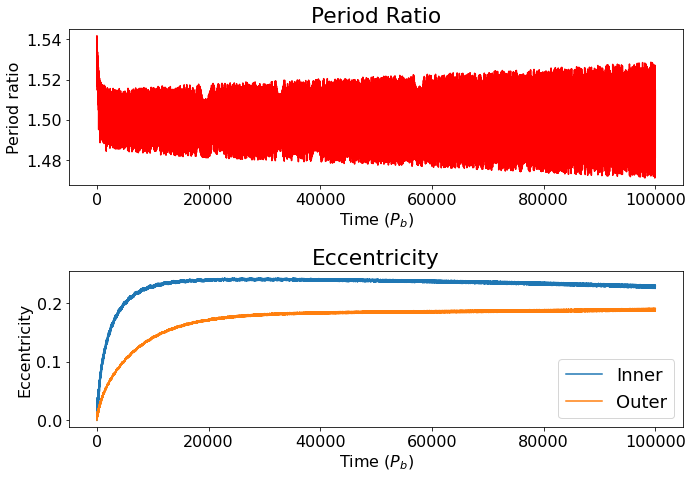

In [30]:
# period ratio
pr = p_outer/p_inner

fig, axs = plt.subplots(2, 1, figsize=(10, 7))
plt.rc('font', size=18)
pr_fig, ecc_fig = axs[0], axs[1]# , axs[0, 1] (no sma fig required)
# period ratio
pr_fig.plot(migration_times, pr, label = 'Period ratio', color='red')
pr_fig.set(xlabel=r'Time ($P_b$)', ylabel='Period ratio', title='Period Ratio')
# pr_fig.set_xlim(right=20000)
# eccentricity
ecc_fig.plot(migration_times, e_inner, label = 'Inner')
ecc_fig.plot(migration_times, e_outer, label = 'Outer')
ecc_fig.set(xlabel = r'Time ($P_b$)', ylabel = 'Eccentricity', title = 'Eccentricity')
# ecc_fig.set_xlim(right=20000)
ecc_fig.legend()
plt.tight_layout()
# plt.savefig('pr_ecc_damping.png', fmt='png')
plt.show()

Now lambdify and use the equations of motion:

In [157]:
# tau values
# use negative values since reboundx takes negative values for timescales
tau_a_1_val, tau_a_2_val, tau_e_1_val, tau_e_2_val = inner.params['tau_a'], outer.params['tau_a'], inner.params['tau_e'], outer.params['tau_e']
# variables y1, y2, x1, x2, D
xyvars = [newvars[i] if i < len(newvars) - 1 else D for i in range(0, len(newvars))]
# make t a symbol again
t = sp.symbols('t')
# and lambdify for use in solving the eom after substituting tau_a, tau_e values
flow_xy = ham_flow_N.subs([(tau_a_1, tau_a_1_val), (tau_a_2, tau_a_2_val), (tau_e_1, tau_e_1_val), (tau_e_2, tau_e_2_val)])
flow_func_xy = sp.lambdify([t, xyvars], flow_xy)
tau_a_1_val, tau_a_2_val, tau_e_1_val, tau_e_2_val

(48868.50808834412, -104855.61284632873, -33333.333333333336, -33333.333333333
336)

Compute Jacobian to use in the IVP solver and lambdify it too:

In [158]:
flow_jac = sp.Matrix(len(xyvars), len(xyvars), lambda i, j: sp.diff(flow_xy[i], xyvars[j]))
flow_jac_func = sp.lambdify([t, xyvars], flow_jac)

Solving using `scipy.integrate.solve_ivp()`:

In [159]:
# Initial values to use:
# the starting hamxy values, plus D_val
y0 = np.append(np.array(ham_xy.values), D_val)
y0, flow_func_xy(t, y0).reshape(-1), flow_jac_func(t, y0)

(array([-1.8387350868967372e-11, 1.1880131114769659e-11,
        -1.1601231938536712e-05, 7.495596158222382e-06,
        9.53862722315180e-11], dtype=object),
 array([ 6.36719069e-05, -4.37304947e-05, -2.91558730e-10,  2.44594077e-10,
         6.05180902e-10]),
 array([[ 2.48840321e-05,  1.28483728e-10, -1.56265118e-01,
          8.10649420e-05,  0.00000000e+00],
        [ 1.28483728e-10,  3.23841480e-05,  8.10649420e-05,
         -1.56192027e-01,  0.00000000e+00],
        [ 1.56139651e-01, -2.03640045e-16,  2.48844298e-05,
         -1.28483728e-10,  0.00000000e+00],
        [-2.03640045e-16,  1.56139651e-01, -1.28483728e-10,
          3.23843140e-05,  0.00000000e+00],
        [-5.51620526e-16,  3.56403933e-16, -3.48036958e-10,
          2.24867885e-10,  0.00000000e+00]]))

In [160]:
from scipy.integrate import solve_ivp
# solve ivp
sols_xy = solve_ivp(lambda t, x: flow_func_xy(t, x).reshape(-1), [migration_times[0], migration_times[-1]], t_eval = migration_times, y0 = y0, jac = lambda t, x: flow_jac_func(t, x), dense_output=True, method='Radau')
sols_xy

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 395392
     njev: 19896
      nlu: 68986
      sol: <scipy.integrate._ivp.common.OdeSolution object at 0x7f09dcf3a790>
   status: 0
  success: True
        t: array([0.00000000e+00, 1.00010001e+01, 2.00020002e+01, ...,
       9.99799980e+04, 9.99899990e+04, 1.00000000e+05])
 t_events: None
        y: array([[-1.83873509e-11,  1.26960248e-04, -1.47326978e-04, ...,
        -8.40474296e-05,  2.42598631e-04, -2.04707844e-04],
       [ 1.18801311e-11, -8.69823859e-05,  1.00917026e-04, ...,
         5.69857892e-05, -1.64915026e-04,  1.38822871e-04],
       [-1.16012319e-05,  4.87458274e-04,  1.75256980e-05, ...,
        -6.05105063e-05,  4.53563563e-04, -1.56388252e-05],
       [ 7.49559616e-06, -3.35065704e-04, -1.21721137e-05, ...,
         3.97673203e-05, -3.11628006e-04,  1.06969320e-05],
       [ 9.53862722e-11,  6.17124777e-09,  1.22603120e-08, ...,
         6.08079690e-05,  6.08140423e-05,  6.

And plotting the result:

In [161]:
# e_inner_eq = np.zeros(len(eq_ivp_sols.y.T))
# e_outer_eq = np.zeros(len(eq_ivp_sols.y.T))
e_inner_rb, e_outer_rb = np.zeros(len(sols_xy.y.T)), np.zeros(len(sols_xy.y.T))

# p_inner_eq, p_outer_eq = np.zeros(len(eq_ivp_sols.y.T)), np.zeros(len(eq_ivp_sols.y.T))
p_inner_rb, p_outer_rb = np.zeros(len(sols_xy.y.T)), np.zeros(len(sols_xy.y.T))

energy = np.zeros(len(sols_xy.y.T))

pvars2 = pvars.copy()
# indices of dynamical variables y1, y2, x1, x2
indices = np.array([ctcomp.new_qp_vars.index(v) for v in ham_xy.qp_vars])
# transofmring pvarsfrom old to new values
y0_2 = ctcomp.old_to_new_array(pvars.values)
    
for i, val in enumerate(sols_xy.y.T):
    # for each value, take the 4 dynamical variables (not including D) and set those as our y0_2 values
    y0_2[indices] = val[0:4]
    # then transform all the way from y, x to eta, kappa before making them pvars
    pvars.values = ctcomp.new_to_old_array(y0_2)
    
    e_inner_rb[i] = pvars.particles[1].e
    e_outer_rb[i] = pvars.particles[2].e
    
    p_inner_rb[i] = pvars.particles[1].P
    p_outer_rb[i] = pvars.particles[2].P
    
    energy[i] = ham_xy.H_func(*y0_2[indices])

Plot eccentricities:

In [162]:
sols_xy.t.shape

(10000,)

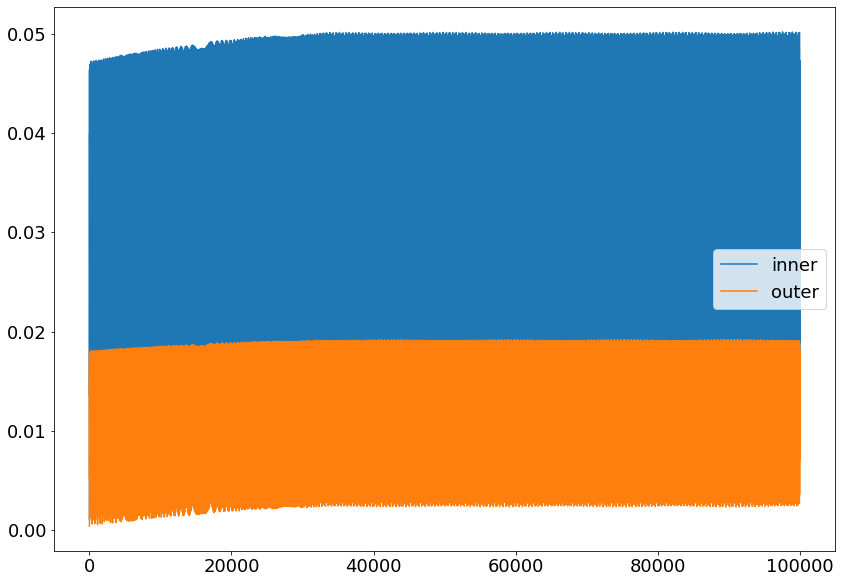

In [163]:
start = 0
end = 10000

plt.figure(figsize = (14, 10))
# plt.plot(eq_ivp_sols.t, e_inner_eq, label = '')
# plt.plot(eq_ivp_sols.t, e_outer_eq, label = '')
plt.plot(sols_xy.t[start:end], e_inner_rb[start:end], label = 'inner')
plt.plot(sols_xy.t[start:end], e_outer_rb[start:end], label = 'outer')
# plt.plot(eq_ivp_sols.t, e_outer_eq, label = 'outer transformed')
# plt.plot(eq_ivp_sols_untransformed.t, e_inner_eq_untransformed, label = 'inner untransformed')
# plt.plot(eq_ivp_sols_untransformed.t, e_outer_eq_untransformed, label = 'outer untrasnformed')
plt.legend()


And energy conservation:

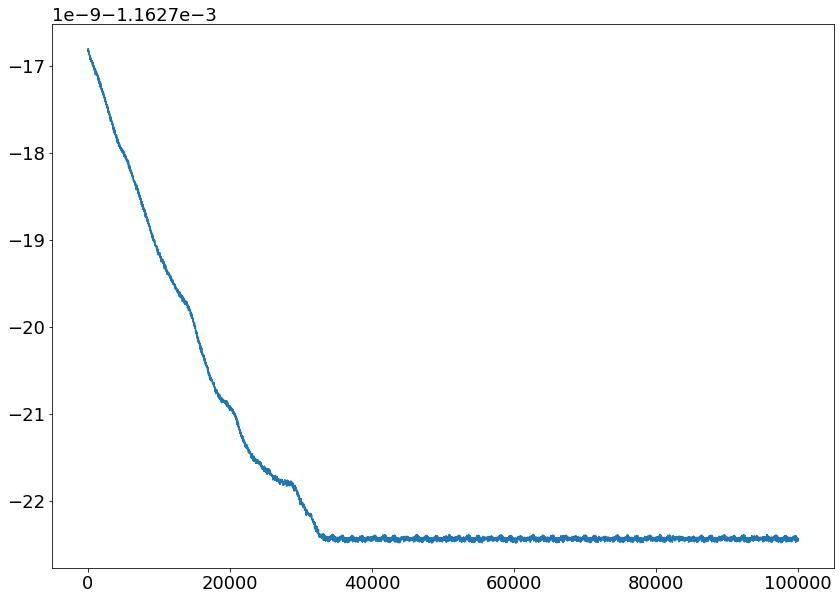

In [165]:
plt.figure(figsize = (14, 10))
plt.plot(sols_xy.t, energy)